##**Clustering**

##### Mount G Drive:

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%cd /content/drive/MyDrive/5008 Project

/content/drive/.shortcut-targets-by-id/1bBIjKsvs3fOfhtXtLG83N0fVmT-uhzTl/5008 Project


##### Import Packages:

In [ ]:
!pip install  dgl -f https://data.dgl.ai/wheels/repo.html

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in links: https://data.dgl.ai/wheels/repo.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.6/5.6 MB 7.6 MB/s eta 0:00:00


In [ ]:
pip install  dglgo -f https://data.dgl.ai/wheels-test/repo.html

In [ ]:
import dgl
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn
import torch
import torch.nn as nn
import torch.nn.functional as F
import scipy.sparse as sp

DGL backend not selected or invalid.  Assuming PyTorch for now.


Setting the default backend to "pytorch". You can change it in the ~/.dgl/config.json file or export the DGLBACKEND environment variable.  Valid options are: pytorch, mxnet, tensorflow (all lowercase)


##### Data Preparation:

In [ ]:
df_cent = pd.read_csv('./Transformed_Data/centrality.csv')
df_clus = pd.read_csv('./Transformed_Data/clustering_coefficient.csv')
df_clus.drop(columns=['node'], inplace=True)

In [ ]:
df = pd.concat([df_cent, df_clus], axis=1)
df['feat'] = df.apply(lambda x: str(x['in_deg_cent']) +","+ str(x["out_deg_cent"])+","+ str(x["btw_cent"])+","+ str(x["cls_cent"])+","+ str(x["eigen_cent"])+","+str(x["clus_coef"]), axis = 1)

In [ ]:
edge = pd.read_csv('./Transformed_Data/route_key_attributes.csv')
edge = pd.concat([edge['src_ap_id'], edge['des_ap_id']], axis=1)
edge.rename(columns={'src_ap_id':'src_id', 'des_ap_id':'dst_id'}, inplace=True)
edge.to_csv('./Final_Code/Clustering/clustering_airport/edges.csv')

In [ ]:
node = df[['node', 'feat']]
node.columns = ['node_id', 'feat']
node.drop_duplicates(inplace = True)
node.to_csv('./Final_Code/Clustering/clustering_airport/nodes.csv', index = 0)

<ipython-input-9-12cd547734e2>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  node.drop_duplicates(inplace = True)


##### Graph Formation:

In [ ]:
dataset = dgl.data.CSVDataset('./Final_Code/Clustering/clustering_airport')
g = dataset[0]  # only one graph
print(g)

Done loading data from cached files.
Graph(num_nodes=3425, num_edges=67719,
      ndata_schemes={'feat': Scheme(shape=(6,), dtype=torch.float32)}
      edata_schemes={})


In [ ]:
edge['weight'] = 1
edge = edge.groupby(['src_id', 'dst_id']).sum().reset_index()

In [ ]:
# Split edge set for training and testing
u, v = g.edges()

# Find all negative edges 
adj = sp.coo_matrix((edge['weight'], (edge['src_id'], edge['dst_id'])), shape=(3425, 3425))
temp = adj.todense()>=1
temp = temp.astype(int)
adj_neg = 1 - temp - np.eye(g.number_of_nodes())
neg_u, neg_v = np.where(adj_neg != 0)

### split the postive and negative graphes
pos_g = dgl.graph(
    (u, v), num_nodes=g.number_of_nodes()
)
neg_g = dgl.graph(
    (neg_u, neg_v), num_nodes=g.number_of_nodes()
)

In [ ]:
print(pos_g)
print(neg_g)

Graph(num_nodes=3425, num_edges=67719,
      ndata_schemes={}
      edata_schemes={})
Graph(num_nodes=3425, num_edges=11689607,
      ndata_schemes={}
      edata_schemes={})


##### Node Embedding:

In [ ]:
node_embed = nn.Embedding(g.number_of_nodes(), 2)  
inputs = node_embed.weight                        
nn.init.xavier_uniform_(inputs)

Parameter containing:
tensor([[-0.0151, -0.0022],
        [-0.0136,  0.0410],
        [-0.0146,  0.0085],
        ...,
        [-0.0152, -0.0121],
        [ 0.0016,  0.0180],
        [-0.0362,  0.0310]], requires_grad=True)

In [ ]:
from dgl.nn import SAGEConv

class Model(nn.Module):
    def __init__(self, input_feats, h_feats):
        super(Model, self).__init__()$

        '''IMPLEMENT: please build the two GraphSAGE layers (use mean as the aggregation)'''
        self.conv1 = SAGEConv(input_feats, h_feats, 'mean')
        self.conv2 = SAGEConv(h_feats, h_feats, 'mean')

    def forward(self, g, in_feat):

        '''IMPLEMENT: the forward computation, with ReLU as the activation function bwtween two layers'''
        h = self.conv1(g, in_feat)
        h = F.relu(h)
        h = self.conv2(g, h)

        return h

model = Model(2,2)

In [ ]:
import dgl.function as fn

class Score(nn.Module):
    def forward(self, g, h):
        with g.local_scope():

            '''IMPLEMENT: compute the dot-product between the features of the incident nodes of an edge'''
            '''the computed results are saved to the 'score' feature of each edge'''
            '''Hint: use g.apply_edges(...) and fn.u_dot_v(...)'''
            g.ndata['h'] = h
            g.apply_edges(fn.u_dot_v('h', 'h', 'score'))
            
            return g.edata['score'][:, 0]

score = Score()

In [ ]:
def compute_loss(pos_score, neg_score):

    scores = torch.cat([pos_score, neg_score])
    labels = torch.cat(
        [torch.ones(pos_score.shape[0]), torch.zeros(neg_score.shape[0])]
    )
    return torch.mean((scores-labels)**2)

In [ ]:
import itertools

optimizer = torch.optim.Adam(itertools.chain(model.parameters(), node_embed.parameters()), lr=0.01)

for e in range(100):
    # forward
    h = model(g,inputs)
    pos_score = score(pos_g,h) 
    neg_score = score(neg_g,h) 
    loss = compute_loss(pos_score, neg_score)
    # backward
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if e % 5 == 0:
        print("In epoch {}, loss: {}".format(e, loss))


/usr/local/lib/python3.10/dist-packages/dgl/backend/pytorch/tensor.py:445: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  assert input.numel() == input.storage().size(), (


In epoch 0, loss: 0.24799811840057373
In epoch 5, loss: 0.013687197118997574
In epoch 10, loss: 0.016674315556883812
In epoch 15, loss: 0.016587328165769577
In epoch 20, loss: 0.01124611310660839
In epoch 25, loss: 0.007782964035868645
In epoch 30, loss: 0.006556864827871323
In epoch 35, loss: 0.006122225429862738
In epoch 40, loss: 0.0059580677188932896
In epoch 45, loss: 0.005891590844839811
In epoch 50, loss: 0.005857713520526886
In epoch 55, loss: 0.005833280738443136
In epoch 60, loss: 0.005811732728034258
In epoch 65, loss: 0.00579235190525651
In epoch 70, loss: 0.005775182042270899
In epoch 75, loss: 0.005759698338806629
In epoch 80, loss: 0.00574493920430541
In epoch 85, loss: 0.0057298243045806885
In epoch 90, loss: 0.005713350139558315
In epoch 95, loss: 0.005694616585969925


##### Clustering:

In [ ]:
num_clus = [x for x in range(1,11)]
squared_dist = []

for cluster in num_clus:
    kmeans = KMeans(n_clusters=cluster, 
                    random_state=0, n_init='auto')\
                  .fit(node_embed.weight.detach().numpy())
    squared_dist.append(kmeans.inertia_)
    
optim_clusters = np.argmin(squared_dist) + 2

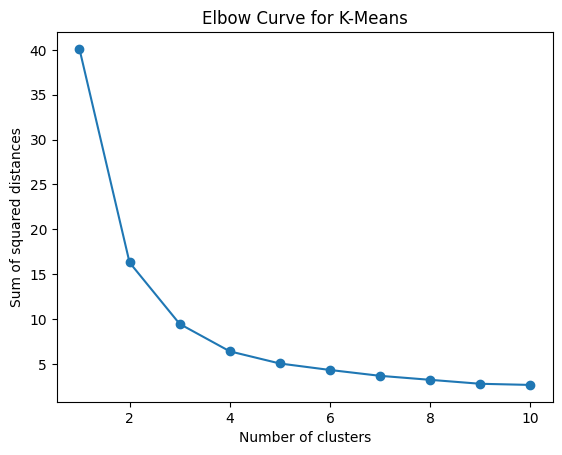

In [ ]:
import matplotlib.pyplot as plt

#Import Kmeans
from sklearn.cluster import KMeans

num_clus = [x for x in range(1,11)]
squared_dist = []

for cluster in num_clus:
    kmeans = KMeans(n_clusters=cluster, random_state=0, n_init='auto').fit(node_embed.weight.detach().numpy())
    squared_dist.append(kmeans.inertia_)
    
optim_clusters = np.argmin(squared_dist) + 2

plt.plot(num_clus, squared_dist, '-o')
plt.title("Elbow Curve for K-Means")
plt.xlabel("Number of clusters")
plt.ylabel("Sum of squared distances")
xy = (optim_clusters, min(squared_dist))
# plt.annotate('(%s, %s)' % xy, xy = xy, textcoords='data')
plt.show()

Experiment with k=3

In [ ]:
kmeans_k3 = KMeans(n_clusters=3, random_state=0, n_init='auto').fit(node_embed.weight.detach().numpy())
pred_labels_k3 = kmeans_k3.labels_

In [ ]:
import pickle
with open("./Saved_Model/kmeans_k3.pkl", "wb") as f:
    pickle.dump(kmeans_k3, f)

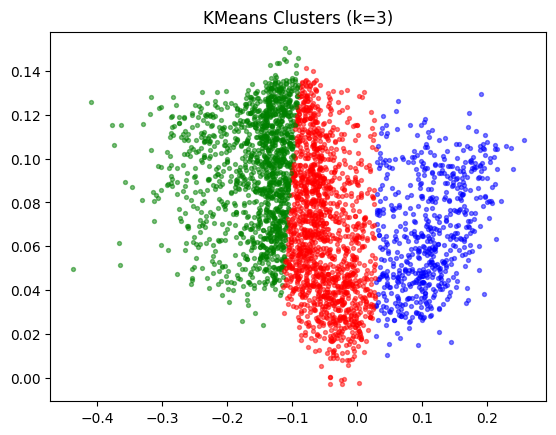

In [ ]:
for ind, node in enumerate(g.nodes()):
  # if ind < 1000:
  if pred_labels_k3[ind] == 0:
    color = 'red'
  elif pred_labels_k3[ind] == 1:
    color = 'blue'
  else:
    color = 'green'
  
  '''please draw the embedding using plt.scatter(), mark the nodes with different colors depends the cluster label you obtained'''  
  plt.scatter(node_embed.weight.detach().numpy()[ind,0], node_embed.weight.detach().numpy()[ind,1], c=color, alpha=0.5, s=8)

  # plt.text(node_embed.weight.detach().numpy()[ind,0]-0.01, node_embed.weight.detach().numpy()[ind,1] , str(int(node.detach().numpy())))

plt.title('KMeans Clusters (k=3)')
plt.show()

Experiment with k=2

In [ ]:
kmeans_k2 = KMeans(n_clusters=2, random_state=0, n_init='auto').fit(node_embed.weight.detach().numpy())
pred_labels_k2 = kmeans_k2.labels_

import pickle
with open("./Saved_Model/kmeans_k2.pkl", "wb") as f:
    pickle.dump(kmeans_k2, f)

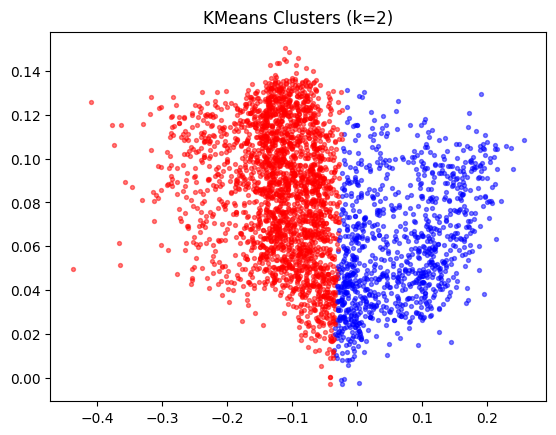

In [ ]:
for ind, node in enumerate(g.nodes()):
  # if ind < 1000:
  if pred_labels_k2[ind] == 0:
    color = 'red'
  else:
    color = 'blue'
  
  '''please draw the embedding using plt.scatter(), mark the nodes with different colors depends the cluster label you obtained'''  
  plt.scatter(node_embed.weight.detach().numpy()[ind,0], node_embed.weight.detach().numpy()[ind,1], c=color, alpha=0.5, s=8)
  
  # plt.text(node_embed.weight.detach().numpy()[ind,0]-0.01, node_embed.weight.detach().numpy()[ind,1] , str(int(node.detach().numpy())))

plt.title('KMeans Clusters (k=2)')
plt.show()

##### Evaluation:

In [ ]:
df.head()

,node,in_deg_cent,out_deg_cent,btw_cent,cls_cent,eigen_cent,pagerank,ap_name,clus_coef,feat,label_k3
0,0,0.005257,0.004965,2.437452e-05,0.276686,0.009110,0.000343,Sochi International Airport,0.525952,"0.0052570093457943,0.004964953271028,2.4374519...",1
1,7,0.006133,0.006133,4.911256e-05,0.278473,0.008890,0.000404,Kazan International Airport,0.423810,"0.0061331775700934,0.0061331775700934,4.911256...",2
2,1,0.002044,0.002044,7.817094e-07,0.266837,0.004766,0.000161,Astrakhan Narimanovo Boris M. Kustodiev Intern...,0.571429,"0.0020443925233644,0.0020443925233644,7.817093...",2
3,9,0.004673,0.004673,2.958986e-05,0.286819,0.009875,0.000311,Mineralnyye Vody Airport,0.495833,"0.0046728971962616,0.0046728971962616,2.958986...",1
4,2,0.004089,0.004089,4.369093e-06,0.268607,0.006755,0.000274,Chelyabinsk Balandino Airport,0.538462,"0.0040887850467289,0.0040887850467289,4.369092...",2


In [ ]:
df['label_k3'] = pd.DataFrame(pred_labels_k3)
df_k3 = df.groupby('label_k3').mean().drop(columns=['node'])
df_k3.reset_index(inplace=True)
df_k3.to_csv('./Transformed_Data/kmeans_results_k3.csv')

In [ ]:
df_k3

,label_k3,in_deg_cent,out_deg_cent,btw_cent,cls_cent,eigen_cent,pagerank,clus_coef
0,0,0.002293,0.002294,0.000653,0.235464,0.004134,0.000239,0.453366
1,1,0.006247,0.006262,0.001761,0.260874,0.012893,0.000472,0.494991
2,2,0.002845,0.002837,0.000767,0.240641,0.005173,0.000270,0.475246


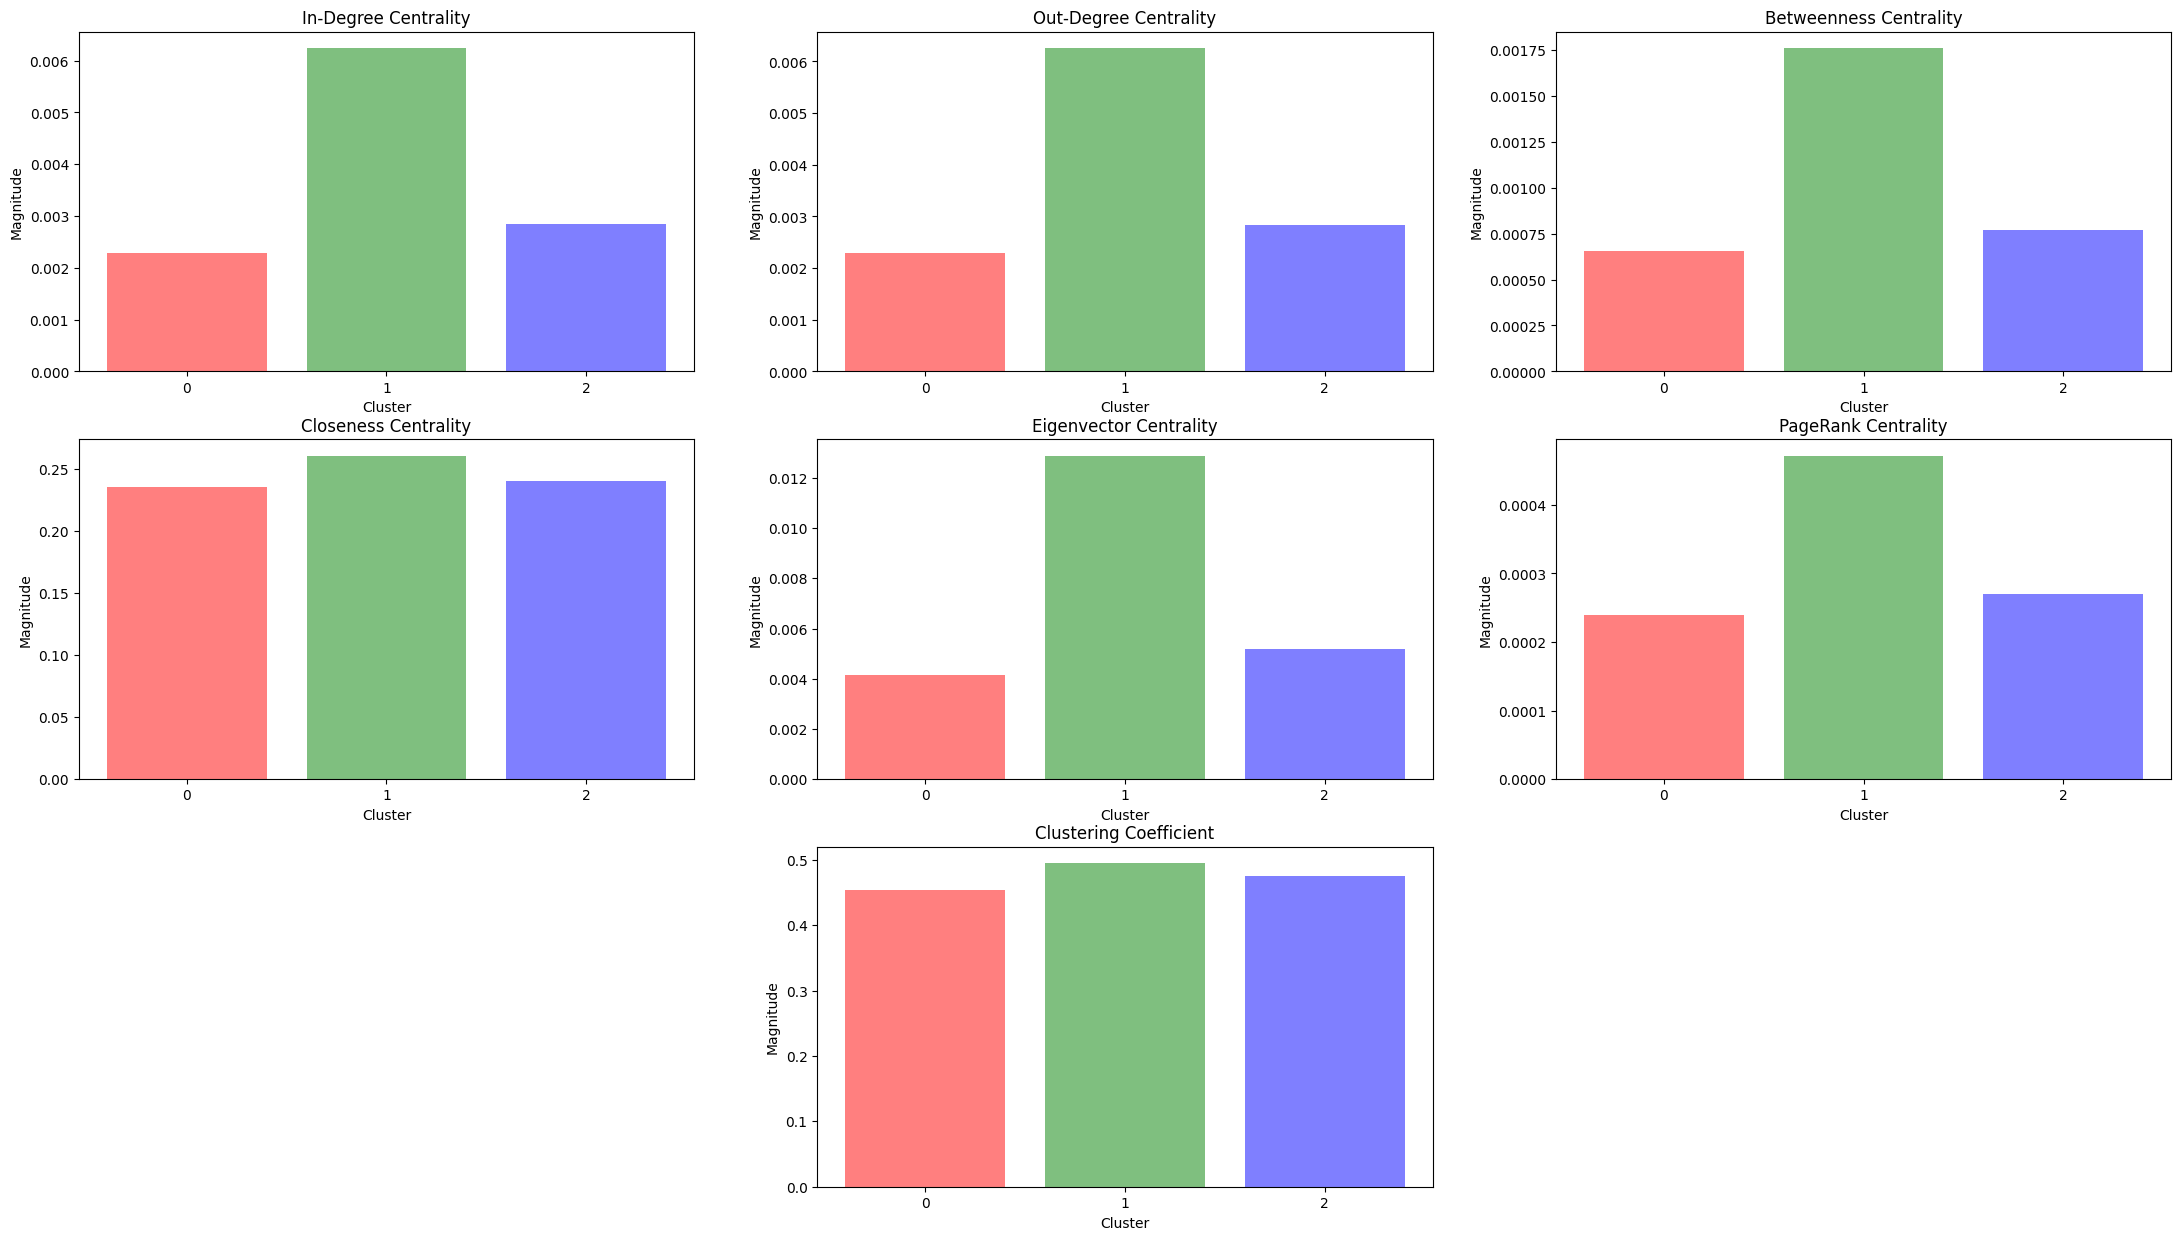

In [ ]:
X = ['Cluster 0', 'Cluster 1', 'Cluster 2']

fig, ((ax1, ax2, ax3), (ax4, ax5, ax6), (ax7, ax8, ax9)) = plt.subplots(3, 3, figsize=(27,15))

ax1.bar(np.arange(len(X)), df_k3['in_deg_cent'], color=['r', 'g', 'b'], alpha=.5)
ax1.set_xticks([0, 1, 2])
ax1.set_xlabel('Cluster')
ax1.set_ylabel('Magnitude')
ax1.set_title('In-Degree Centrality')

ax2.bar(np.arange(len(X)), df_k3['out_deg_cent'], color=['r', 'g', 'b'], alpha=.5)
ax2.set_xticks([0, 1, 2])
ax2.set_xlabel('Cluster')
ax2.set_ylabel('Magnitude')
ax2.set_title('Out-Degree Centrality')

ax3.bar(np.arange(len(X)), df_k3['btw_cent'], color=['r', 'g', 'b'], alpha=.5)
ax3.set_xticks([0, 1, 2])
ax3.set_xlabel('Cluster')
ax3.set_ylabel('Magnitude')
ax3.set_title('Betweenness Centrality')

ax4.bar(np.arange(len(X)), df_k3['cls_cent'], color=['r', 'g', 'b'], alpha=.5)
ax4.set_xticks([0, 1, 2])
ax4.set_xlabel('Cluster')
ax4.set_ylabel('Magnitude')
ax4.set_title('Closeness Centrality')

ax5.bar(np.arange(len(X)), df_k3['eigen_cent'], color=['r', 'g', 'b'], alpha=.5)
ax5.set_xticks([0, 1, 2])
ax5.set_xlabel('Cluster')
ax5.set_ylabel('Magnitude')
ax5.set_title('Eigenvector Centrality')

ax6.bar(np.arange(len(X)), df_k3['pagerank'], color=['r', 'g', 'b'], alpha=.5)
ax6.set_xticks([0, 1, 2])
ax6.set_xlabel('Cluster')
ax6.set_ylabel('Magnitude')
ax6.set_title('PageRank Centrality')

ax8.bar(np.arange(len(X)), df_k3['clus_coef'], color=['r', 'g', 'b'], alpha=.5)
ax8.set_xticks([0, 1, 2])
ax8.set_xlabel('Cluster')
ax8.set_ylabel('Magnitude')
ax8.set_title('Clustering Coefficient')

fig.delaxes(ax7)
fig.delaxes(ax9)

In [ ]:
df['label_k2'] = pd.DataFrame(pred_labels_k2)
df_k2 = df.groupby('label_k2').mean().drop(columns=['node', 'label_k3'])
df_k2.reset_index(inplace=True)
df_k2.to_csv('./Transformed_Data/kmeans_results_k2.csv')

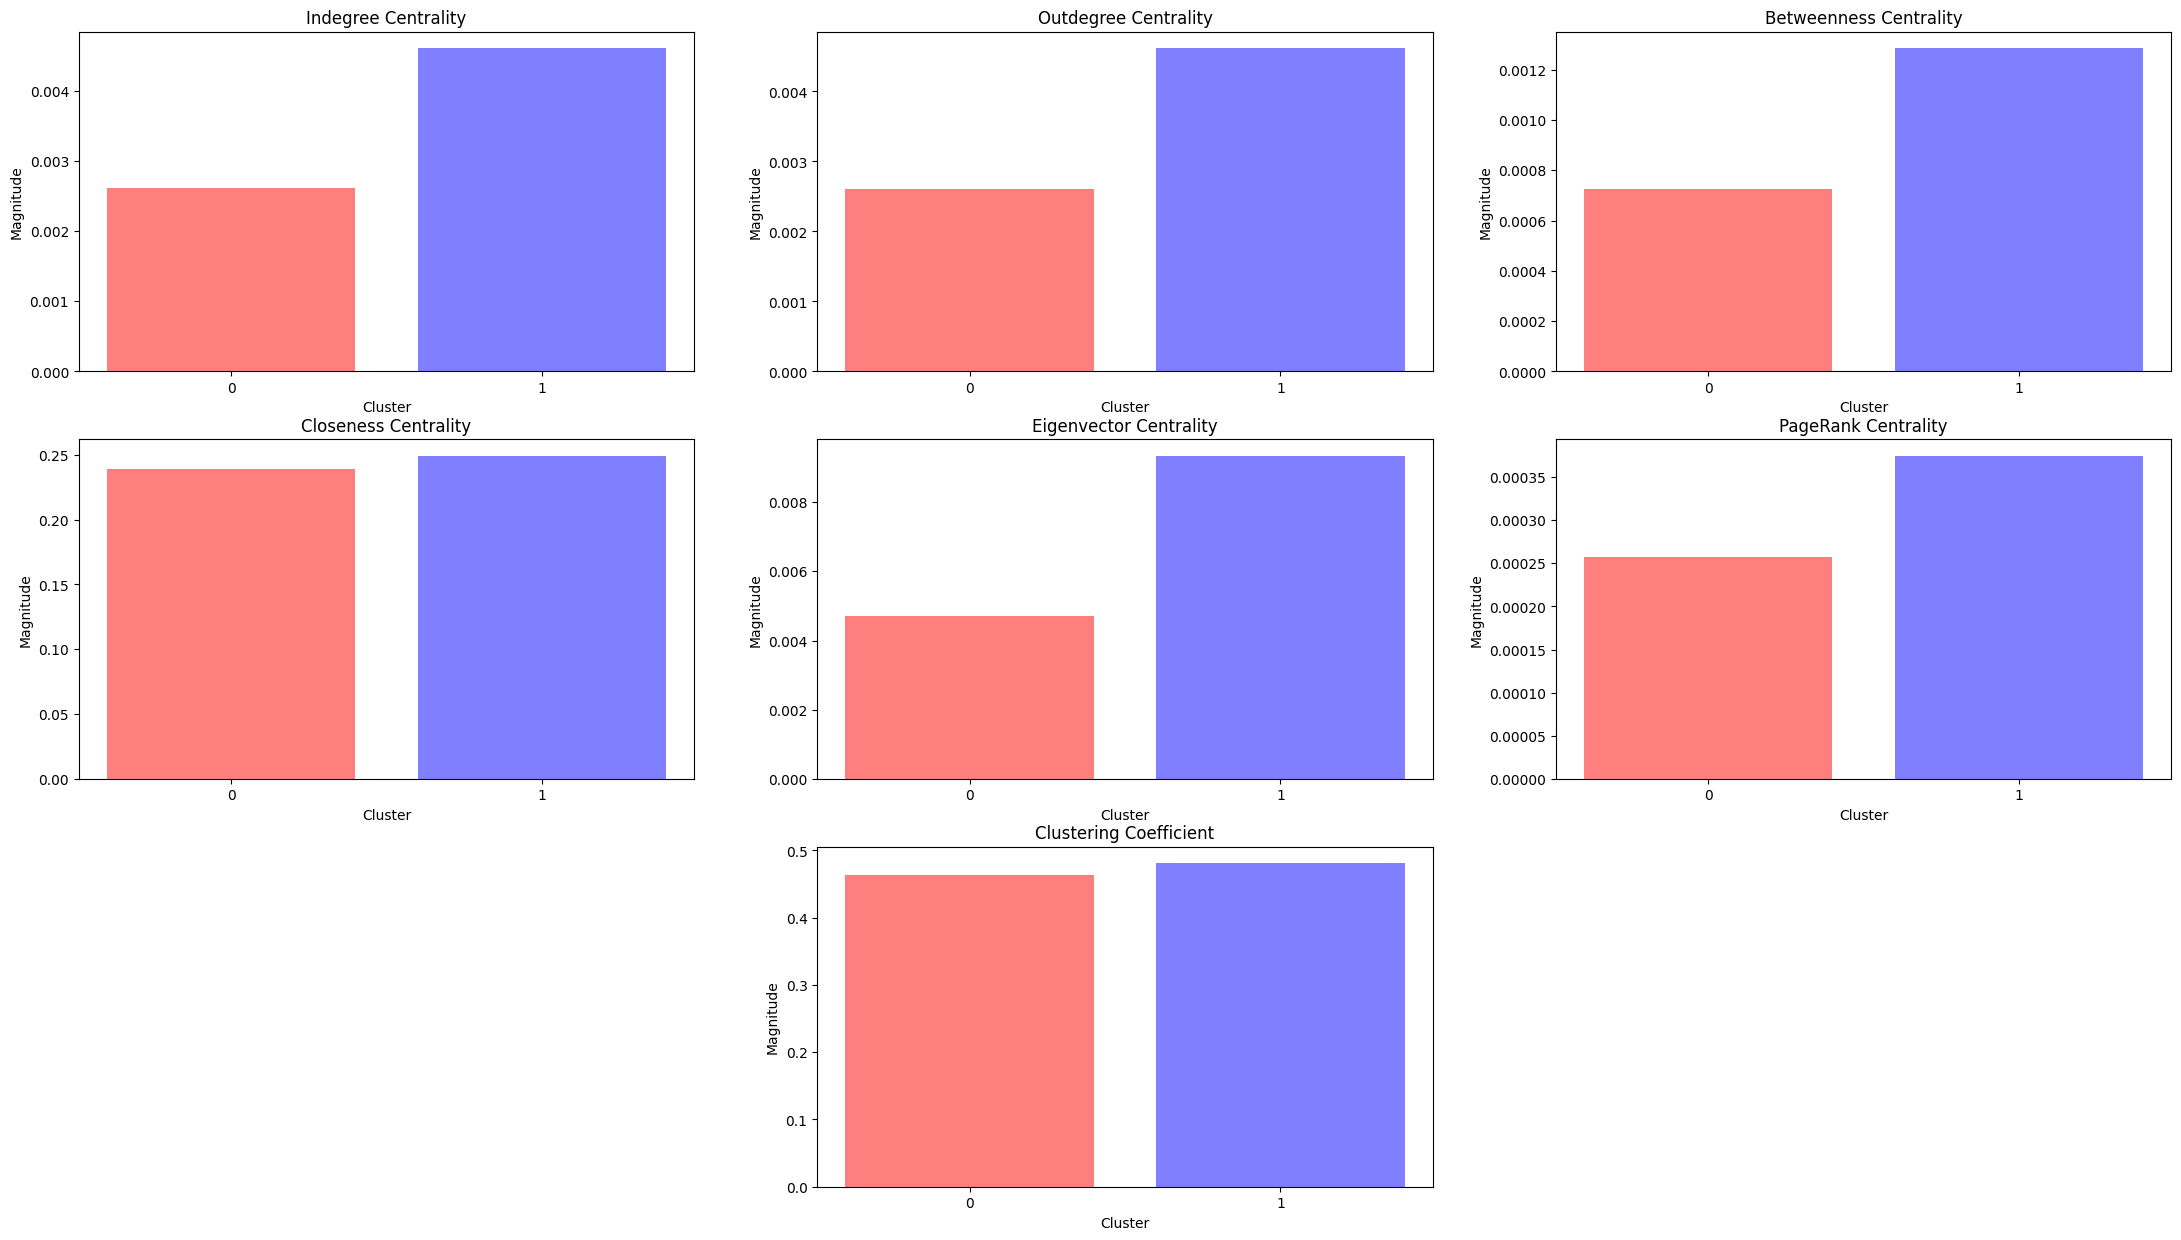

In [ ]:
X = ['Cluster 0', 'Cluster 1']

fig, ((ax1, ax2, ax3), (ax4, ax5, ax6), (ax7, ax8, ax9)) = plt.subplots(3, 3, figsize=(27,15))

ax1.bar(np.arange(len(X)), df_k2['in_deg_cent'], color=['r', 'b'], alpha=.5)
ax1.set_xticks([0, 1])
ax1.set_xlabel('Cluster')
ax1.set_ylabel('Magnitude')
ax1.set_title('Indegree Centrality')

ax2.bar(np.arange(len(X)), df_k2['out_deg_cent'], color=['r', 'b'], alpha=.5)
ax2.set_xticks([0, 1])
ax2.set_xlabel('Cluster')
ax2.set_ylabel('Magnitude')
ax2.set_title('Outdegree Centrality')

ax3.bar(np.arange(len(X)), df_k2['btw_cent'], color=['r', 'b'], alpha=.5)
ax3.set_xticks([0, 1])
ax3.set_xlabel('Cluster')
ax3.set_ylabel('Magnitude')
ax3.set_title('Betweenness Centrality')

ax4.bar(np.arange(len(X)), df_k2['cls_cent'], color=['r', 'b'], alpha=.5)
ax4.set_xticks([0, 1])
ax4.set_xlabel('Cluster')
ax4.set_ylabel('Magnitude')
ax4.set_title('Closeness Centrality')

ax5.bar(np.arange(len(X)), df_k2['eigen_cent'], color=['r', 'b'], alpha=.5)
ax5.set_xticks([0, 1])
ax5.set_xlabel('Cluster')
ax5.set_ylabel('Magnitude')
ax5.set_title('Eigenvector Centrality')

ax6.bar(np.arange(len(X)), df_k2['pagerank'], color=['r', 'b'], alpha=.5)
ax6.set_xticks([0, 1])
ax6.set_xlabel('Cluster')
ax6.set_ylabel('Magnitude')
ax6.set_title('PageRank Centrality')

ax8.bar(np.arange(len(X)), df_k2['clus_coef'], color=['r', 'b'], alpha=.5)
ax8.set_xticks([0, 1])
ax8.set_xlabel('Cluster')
ax8.set_ylabel('Magnitude')
ax8.set_title('Clustering Coefficient')

fig.delaxes(ax7)
fig.delaxes(ax9)